# API Facturas
API para la extraccion de facturas del sitio del SAT

## 0. Carga de librerias

In [531]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import base64
from PIL import Image #Libreria para el manejod e imagenes
import io
from selenium.webdriver.support.ui import Select
import selenium.webdriver.support.ui as ui
from selenium.webdriver.common.action_chains import ActionChains
import time
from tqdm import tqdm_notebook as tqdm
from os import listdir, remove
from os.path import isfile, join
import pathlib

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from selenium.webdriver.support import expected_conditions as EC

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


## 1. Funciones

In [722]:
#lookuptag

#Descripción General: Funcion para buscar un texto específico en etiquetas similares
#Recibe: Lista de elementos (list_elements) que puede venir de un driver.find_elements...
#Recibe: Texto para comparar (selected_string) que debe ser igual al texto que se esta buscando
#Recibe: Despligue (verbose) para ver todos los elementos de la lista. False por default
#Regresa: Elemento seleccionado o en caso de no encontrar nada None

def lookuptag(list_elements,selected_string,verbose=False):
    if verbose == True:
        for i,e in enumerate(list_elements):
            print(i,":", e.text)
    else:
        pass
    
    for i,e in enumerate(list_elements):
        if e.text == selected_string:
            return e
        else:
            pass
    return None

In [609]:
#loadok

#Descripcion General: Funcion para asegurar la carga de una página despues de una secuencia
#Recibe: elemento de Selenium
#Recibe: tiempo en segundos de cada refrescado (refresh)
#Recibe: Maximo número de intentos para varificar que el elemento se cargo (max_tries)
#Recibe: Una etiqueta para identificar el elemento de prueba (stage) por default ""
#Recibe: Despliegue (verbose) para verificar el estado de la validación
#Regresa: None

def loadok(element, refresh=1, max_tries=3, stage="",verbose=True):
    loaded=False
    tries=0
    
    while 1:
        try:
            element
            loaded=True
            if verbose == True:
                return print(stage+"loaded [ok]")
            else:
                return None
        except:
            tries = tries + 1
            loaded=False
            time.sleep(refresh*tries)
            
            if tries >= max_tries:
                if verbose == True:
                    return print("Número de intentos superado. La página no ha cargado correctamente")
                else:
                    return None
    
    

## 2. Login en  página del SAT

Recibe Datos de Usuario y Captcha

loaded [ok]


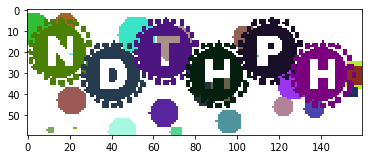

In [709]:
#Deteccion de la raiz de los archivos
directorio=pathlib.Path().absolute()
filespath=str(directorio)+'/temp'

#Seleccion de carpeta temporal para descarga de archivow
chrome_options = webdriver.ChromeOptions()
prefs = {'download.default_directory' : filespath}
chrome_options.add_experimental_option('prefs', prefs)
options = webdriver.ChromeOptions() 
options.add_argument("download.default_directory="+filespath)

#Inicializacion de driver de Selenium
driver = webdriver.Chrome(chrome_options=chrome_options)

#Inicializar Navegador y entrar a pagina web
driver.get("https://portalcfdi.facturaelectronica.sat.gob.mx/")

#Espera dináminca de la carga del captcha
loadok(driver.find_elements_by_tag_name("img"))

#Obtener Captcha
images=driver.find_elements_by_tag_name("img")
captcha = images[1].get_attribute('src')[23:]

#Integrar Captcha
image_decoded = base64.b64decode(str(captcha))       
image = Image.open(io.BytesIO(image_decoded))

#Mostrar captcha en jupiter notebook
imgplot = plt.imshow(image)
plt.show()

#Guardar Captcha

#fileName = 'captcha.jpeg'
#imagePath = ("captcha.jpeg")
#image.save(imagePath, 'jpeg')

In [710]:
#Enviar Captcha y solicitar rfc, pwd y cap
#str_rfc=input("Ingresa tu RFC:")
#str_pwd=input("Ingresa tu contraseña:")
str_rfc='IADA810218HG5'
str_pwd='DaSa0520'
str_cap=input("Ingresa el Captcha:")

Ingresa el Captcha:NDTHPH


## 3. Robot de navegacion y descarga de facturas

In [711]:
#Ingreso de credenciales
rfc = driver.find_element_by_id("rfc")
rfc.clear()
rfc.send_keys(str_rfc)

pwd=driver.find_element_by_id("password")
pwd.clear()
pwd.send_keys(str_pwd)

cap=driver.find_element_by_id("userCaptcha")
cap.clear()
cap.send_keys(str_cap)

btn_Login=driver.find_element_by_id("submit")
btn_Login.click()

#Click en Consultar Facturas Recibidas
loadok(driver.find_element_by_link_text("Consultar Facturas Recibidas"))
lnk_Emitidas= driver.find_element_by_link_text("Consultar Facturas Recibidas")
lnk_Emitidas.click()

#Selección del tipo de busqueda de facturas "Por fecha"
loadok(driver.find_element_by_id("ctl00_MainContent_RdoFechas"))
sel_fecha_emision=driver.find_element_by_id("ctl00_MainContent_RdoFechas")
sel_fecha_emision.click()

#Selección del mes
mes= 12 if time.localtime().tm_mon == 1 else time.localtime().tm_mon
loadok(Select(driver.find_element_by_id('ctl00_MainContent_CldFecha_DdlMes')))
sel_mes = Select(driver.find_element_by_id('ctl00_MainContent_CldFecha_DdlMes'))
sel_mes.select_by_value(mes)

#Click en el boton de búsqueda de las facturas del mes
loadok(driver.find_element_by_name("ctl00$MainContent$BtnBusqueda"))
btn_BuscarCFDI=driver.find_element_by_name("ctl00$MainContent$BtnBusqueda")
btn_BuscarCFDI.click()


#Seleccion del Año

anno= time.localtime().tm_year - 1 if time.localtime().tm_mon == 1 else time.localtime().tm_year

## Scraping pendiente de la seleccion del año ------------------ !!!!

#Descarga de todas las facturas en las páginas disponibles
fallos=[]
btns_Descarga=[]
btns_Descarga = driver.find_elements_by_id("BtnDescarga")

for j in tqdm(range(len(btns_Descarga)),'Facturas'):
    try:
        driver.execute_script(btns_Descarga[j].get_attribute('onclick')) #Ejecuta el metodo de Java Script para la descarga
        #Verificacion de descarga --- OPTIMIZACION PENDIENTE TIP: Comparar nombre de archivo con el desplegado en la pagina
        time.sleep(3)
        loadok(driver.switch_to_window(driver.window_handles[1]),stage=str(j),verbose=False) #Mueve el foco a la ventana de descarga
        driver.close()  #Cierra pagina de descarga
        driver.switch_to_window(driver.window_handles[0])    
    except:
        fallos.append(j)

loaded [ok]
loaded [ok]
loaded [ok]
loaded [ok]


In [719]:
#Cambio a Pagina de Facturas Emitidas

#Regreso a Inicio
loadok(driver.find_elements_by_tag_name('a'))
btn_Inicio=lookuptag(driver.find_elements_by_tag_name('a'), 'Inicio')
btn_Inicio.click()

#Click en Consultar Facturas Recibidas
loadok(driver.find_element_by_link_text("Consultar Facturas Emitidas"))
lnk_Emitidas= driver.find_element_by_link_text("Consultar Facturas Emitidas")
lnk_Emitidas.click()

#Selección del tipo de busqueda de facturas "Por fecha"
loadok(driver.find_element_by_id("ctl00_MainContent_RdoFechas"))
sel_fecha_emision=driver.find_element_by_id("ctl00_MainContent_RdoFechas")
sel_fecha_emision.click()
#Selección de fechas inicial y final
fecha_inicial="'01/01/2020'"
driver.execute_script("updateDateField('ctl00$MainContent$CldFechaInicial2$Calendario_text',"+fecha_inicial+");")
fecha_final="'31/01/2020'"
driver.execute_script("updateDateField('ctl00$MainContent$CldFechaFinal2$Calendario_text',"+fecha_final+");")
#Click en el boton de búsqueda de las facturas del mes
loadok(driver.find_element_by_name("ctl00$MainContent$BtnBusqueda"))
btn_BuscarCFDI=driver.find_element_by_name("ctl00$MainContent$BtnBusqueda")
btn_BuscarCFDI.click()

loaded [ok]
loaded [ok]
loaded [ok]
loaded [ok]


In [721]:
#Descarga de facturas emitidas
fallos=[]
btns_Descarga=[]
btns_Descarga = driver.find_elements_by_id("BtnDescarga")

for j in tqdm(range(len(btns_Descarga)),'Facturas'):
    try:
        driver.execute_script(btns_Descarga[j].get_attribute('onclick')) #Ejecuta el metodo de Java Script para la descarga
        #Verificacion de descarga --- OPTIMIZACION PENDIENTE TIP: Comparar nombre de archivo con el desplegado en la pagina
        time.sleep(3)
        loadok(driver.switch_to_window(driver.window_handles[1]),stage=str(j),verbose=False) #Mueve el foco a la ventana de descarga
        driver.close()  #Cierra pagina de descarga
        driver.switch_to_window(driver.window_handles[0])    
    except:
        fallos.append(j)

In [723]:
#Fin del API de descarga de facturas
driver.close()